## Домашнее задание №6

### 1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев.  Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import numpy as np
import random
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [2]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [3]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции.

In [4]:
def bias(z, y):
    return 2 * (z - y)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

Реализуем функцию обучения градиентного бустинга.

In [6]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Обучим несколько моделей с разным количеством деревьев и посмотрим как оно влияет на ошибку

In [7]:
max_depth = 3
eta = 0.05
list_mse = []
for n_trees in range(1, 81, 10):
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    round(mean_squared_error(y_test, test_prediction))
    list_mse.append([n_trees, round(mean_squared_error(y_train, train_prediction)), round(mean_squared_error(y_test, test_prediction))])
    

In [8]:
list_mse

[[1, 27244.0, 24347.0],
 [11, 5543.0, 5247.0],
 [21, 2435.0, 3074.0],
 [31, 1815.0, 2982.0],
 [41, 1558.0, 2982.0],
 [51, 1389.0, 3053.0],
 [61, 1244.0, 3119.0],
 [71, 1154.0, 3172.0]]

Построим графики зависимости ошибки на обучающей и тестовой выборках от количества деревьев в ансабле.

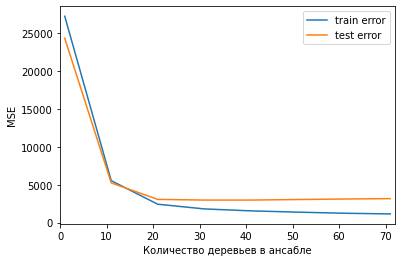

In [9]:
plt.xlabel('Количество деревьев в ансабле')
plt.ylabel('MSE')
plt.xlim(0, list(zip(*list_mse))[0][-1] + 1)
plt.plot(list(zip(*list_mse))[0], list(zip(*list_mse))[1], label='train error')
plt.plot(list(zip(*list_mse))[0], list(zip(*list_mse))[2], label='test error')
plt.legend(loc='best')
plt.show()

Теперь обучим несколько моделей с разной глубиной деревьев и посмотрим как глубина влияет на ошибку

In [10]:
n_trees = 20
eta = 0.05
list_mse = []
for max_depth in range(1, 7):
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    round(mean_squared_error(y_test, test_prediction))
    list_mse.append([max_depth, round(mean_squared_error(y_train, train_prediction)), round(mean_squared_error(y_test, test_prediction))])
    

Построим графики зависимости ошибки на обучающей и тестовой выборках от максимальной глубины деревьев в ансабле.

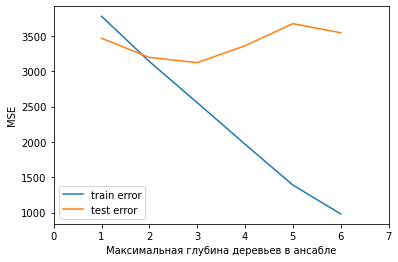

In [11]:
plt.xlabel('Максимальная глубина деревьев в ансабле')
plt.ylabel('MSE')
plt.xlim(0, list(zip(*list_mse))[0][-1] + 1)
plt.plot(list(zip(*list_mse))[0], list(zip(*list_mse))[1], label='train error')
plt.plot(list(zip(*list_mse))[0], list(zip(*list_mse))[2], label='test error')
plt.legend(loc='best')
plt.show()

#### Выводы:
1. На графках отчетливо видно, что на обучающей выборке при увеличении количества дереьев и максимальной глубины деревьев ошибка постоянно умньшается
2. На тестовой выборке до опрелеленого момента при увеличении количества дереьев и максимальной глубины деревьев ошибка также умньшается
3. После некоторых значений даных гиперпараметров ошибка на тестовой выборке становиться все больше, чем на обучающей, показывая тем самым переобучение модели
4. При дальнейшем увеличении значений данных гиперпараметров наступает такой момент, после которого ошибка на тестовой выборке вообще начинает увеличиваться

### 2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [12]:
# Создадим функцию для формирования случайных наборов обучающих признаков 
def get_stochastic_data(data, labels, n_trees):
    n_samples = int(X_train.shape[0]*0.5)
    stochastic_data = []
    
    for i in range(n_trees):
        b_data = np.zeros(data[:n_samples].shape)
        b_labels = np.zeros(labels[:n_samples].shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        stochastic_data.append((b_data, b_labels))
        
    return stochastic_data

In [13]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    stochastic_data = get_stochastic_data(X_train, y_train, n_trees)
        
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        X_train, y_train = stochastic_data[i][0], stochastic_data[i][1]
        

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [14]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.05

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [52]:
test_errors

[24352.018177889797,
 24352.018177889797,
 20174.233067110566,
 16827.461929944642,
 14145.118203572792,
 11908.7435124343,
 10168.287085396425,
 8761.74231287536,
 7679.266283527152,
 6760.926782609632,
 5988.3735653758295,
 5383.001916241956,
 4946.9729081678415,
 4546.938262690729,
 4257.657517742874,
 3992.3083255373303,
 3775.1943248690895,
 3628.0911838071092,
 3486.608877049317,
 3372.9550691014306,
 3298.9625511157856,
 3238.686892283594,
 3172.049699766943,
 3114.413746776039,
 3076.1748047457722,
 3030.5784070748746,
 3012.9294179289514,
 2982.9826875993704,
 2953.3212177232085,
 2929.760092443027,
 2924.415337374638,
 2917.1335662535666,
 2911.922522741922,
 2895.874233096451,
 2883.127261201743,
 2870.7669517273016,
 2860.828241180026,
 2864.533704865219,
 2850.845765221888,
 2842.1135277359876,
 2840.64410335889,
 2847.1149889090834,
 2852.435367509558,
 2847.30251900122,
 2836.8390451614573,
 2826.4483351904464,
 2832.040591118581,
 2832.9465945741417,
 2857.9821956806395

In [16]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

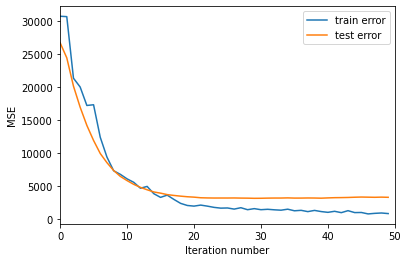

In [17]:
get_error_plot(n_trees, train_errors, test_errors)

Видим характернкю ломанную линию отражающую неравномерный процесс обучения при стохастическом градиентном бустинге. Однако ошибка на тестовой выборке снижалась плавно и достигла примерно аналогичных значений с классическим бустингом при одинаковых гиперпараметрах.

### 3. (\*) Модифицировать алгоритм градиетного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [20]:
# Реализуем класс узла
class Node:
   
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [21]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction        

In [22]:
# Расчет дисперсии
def variance(labels):

    impurity = np.var(labels) 
    return impurity

In [23]:
# Расчет качества
def quality(left_labels, right_labels, current_variance):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_variance - p * variance(left_labels) - (1 - p) * variance(right_labels)

In [24]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [25]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_variance = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
           
        #  пропускаем разбиения, в которых в узле остается менее 5 объектов    
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_variance)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [26]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [27]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Органичим глубину дерева

In [35]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, max_depth):
    global depth, true_branch, false_branch
#     print("Глубина", depth)
    quality, t, index = find_best_split(data, labels)

#      Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
#         print("quality == 0")
    
    if depth == 3:
        return Leaf(data, labels)
    
    # Рекурсивно строим два поддерева
#     print("Делаем ветвление на глубине ", depth)
    depth += 1
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels, depth)
    false_branch = build_tree(false_data, false_labels, depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [36]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([eta * coef * predict([x], alg)[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

Обучим несколько моделей с разным количеством деревьев и посмотрим как оно влияет на ошибку

In [42]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    global depth
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
   
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            
            depth = 0
            true_branch = None
            false_branch = None
            my_tree = build_tree(X_train, y_train, max_depth)
            trees.append(my_tree)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            
            depth = 0
            true_branch = None
            false_branch = None
            my_tree = build_tree(X_train, bias(y_train, target), max_depth)

            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

            trees.append(my_tree)
        
    return trees, train_errors, test_errors

In [43]:
max_depth = 3
eta = 0.05
list_mse = []
for n_trees in range(1, 81, 10):
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    round(mean_squared_error(y_test, test_prediction))
    list_mse.append([n_trees, round(mean_squared_error(y_train, train_prediction)), round(mean_squared_error(y_test, test_prediction))])
    

In [44]:
list_mse

[[1, 27317.0, 24352.0],
 [11, 6108.0, 5383.0],
 [21, 3109.0, 3239.0],
 [31, 2576.0, 2917.0],
 [41, 2431.0, 2847.0],
 [51, 2315.0, 2854.0],
 [61, 2205.0, 2899.0],
 [71, 2122.0, 2905.0]]

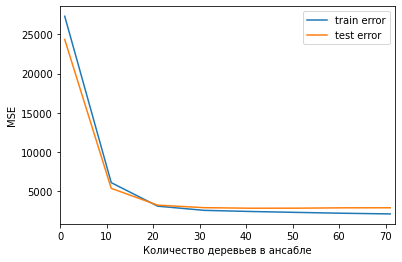

In [45]:
plt.xlabel('Количество деревьев в ансабле')
plt.ylabel('MSE')
plt.xlim(0, list(zip(*list_mse))[0][-1] + 1)
plt.plot(list(zip(*list_mse))[0], list(zip(*list_mse))[1], label='train error')
plt.plot(list(zip(*list_mse))[0], list(zip(*list_mse))[2], label='test error')
plt.legend(loc='best')
plt.show()

#### Выводы:
Качество алгоритма на основе решающего дерева из ДЗ_4 оказалось лучше по стравнению с реализацией из п.1. Ошибка, полученная при его работе оказалась меньше. Также алгоритм оказался менее склонен к переобучению, что видно из графиков и тпблиц.